IntSlider(value=3, description='Mana Cost:', max=10)

SelectMultiple(description='Colors:', options=('Red', 'Blue', 'Green', 'White', 'Black', 'Colorless'), value=(…

SelectMultiple(description='Keywords:', options=('Vigilance', 'Trample', 'Reach', 'Prowess', 'Protection', 'Me…

Button(description='Calculate Win Rate', style=ButtonStyle())

Button(description='Clear Selections', style=ButtonStyle())

Output()

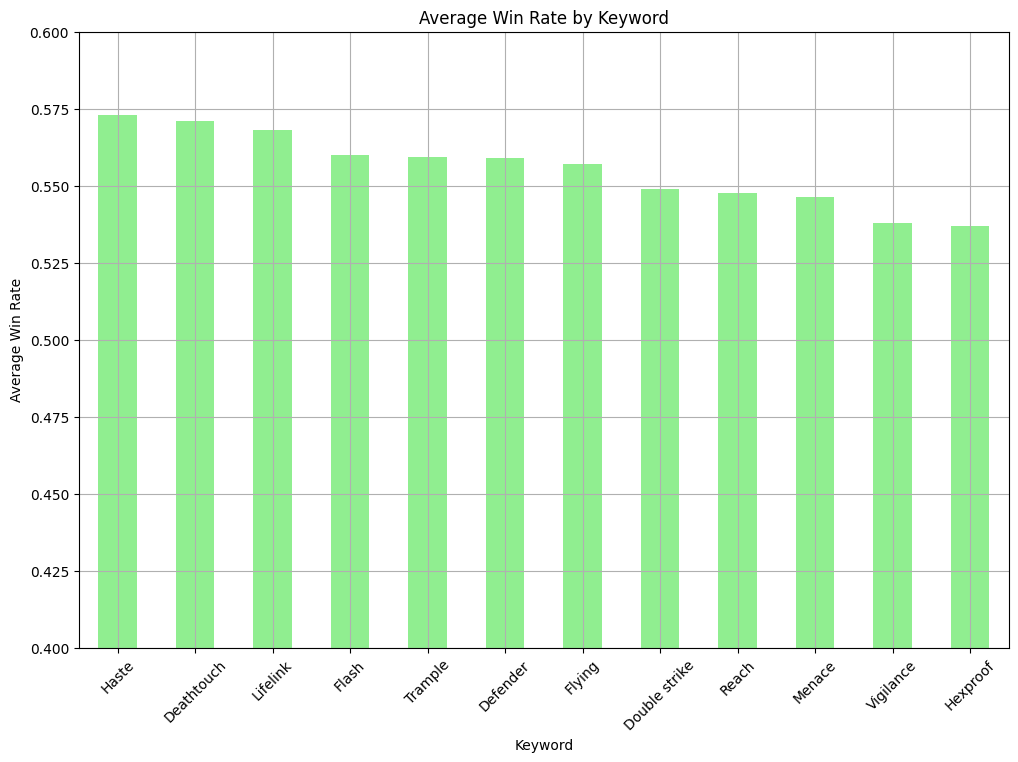

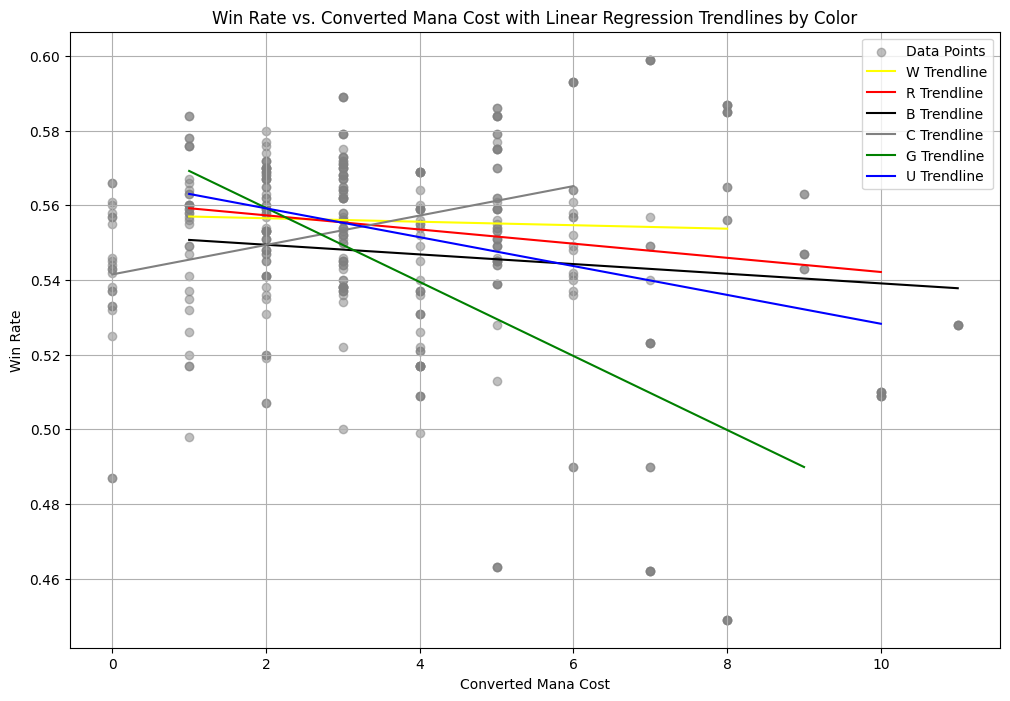

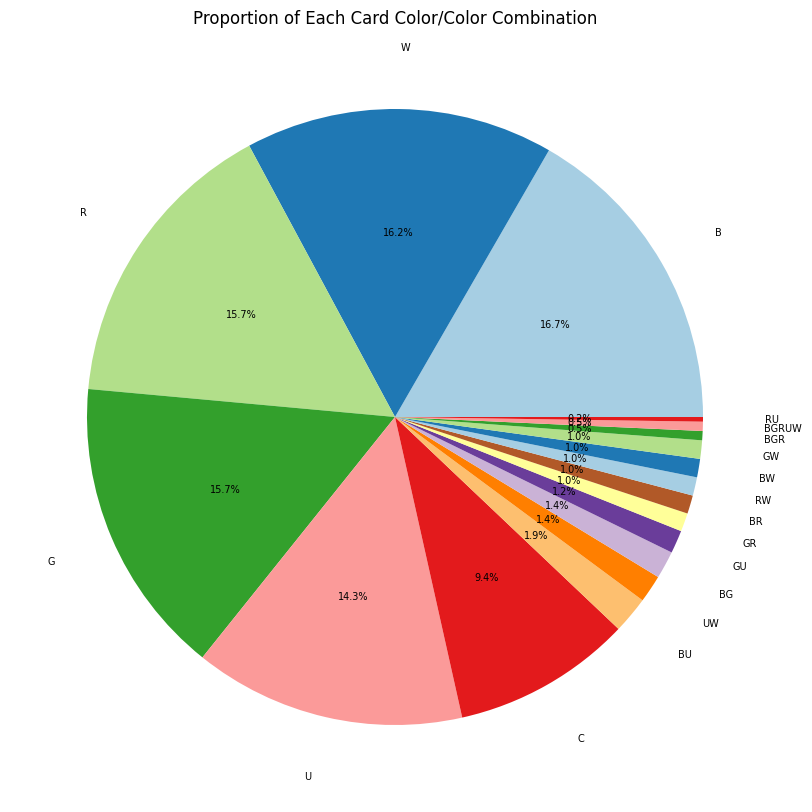

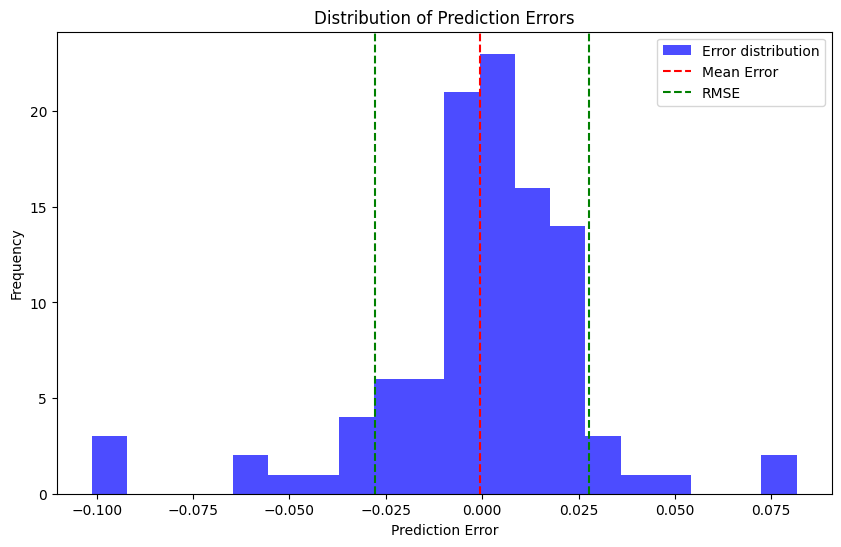

Model evaluation:
Mean Squared Error: 0.000769055429420827
Root Mean Squared Error: 0.027731848647734016


In [14]:
import os
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error


def normalize_colors(color_string):
    if pd.isna(color_string) or color_string.strip() == '':
        return 'C'
    return ''.join(sorted(color_string.strip()))

def prepare_colors_for_plotting(color_string):
    if pd.isna(color_string) or color_string.strip() == '':
        return ['C']  # Handle empty or NaN values

    # List all expected colors
    colors = ['Red', 'Blue', 'Green', 'White', 'Black']
    color_list = []

    # Check for each color in the string
    for color in colors:
        if color in color_string:
            color_list.append(color)
    
    return color_list if color_list else ['C']  # Return 'Colorless' if no known colors are found



# Define the evergreen keywords
evergreen_keywords = [
    "Vigilance", "Trample", "Reach", "Prowess", "Protection",
    "Menace", "Lifelink", "Indestructible", "Hexproof", "Haste",
    "Flying", "Flash", "First strike", "Double strike", "Defender", "Deathtouch"
]

# Paths to the folders
csv_folder_path = './CSV'
json_folder_path = './JSON'

# Create an empty DataFrame to accumulate all merged data
all_merged_data = pd.DataFrame()

# List CSV and JSON files
csv_files = [f for f in os.listdir(csv_folder_path) if f.endswith('.csv')]
json_files = [f for f in os.listdir(json_folder_path) if f.endswith('.json')]

for csv_file, json_file in zip(sorted(csv_files), sorted(json_files)):
    # Load CSV
    csv_path = os.path.join(csv_folder_path, csv_file)
    csv_data = pd.read_csv(csv_path)
    csv_data['GP WR'] = csv_data['GP WR'].astype(str).str.strip().str.replace('%', '').str.replace(' ', '').astype(float) / 100
    csv_data['Normalized Colors'] = csv_data['Color'].apply(normalize_colors)

    # Load JSON
    json_path = os.path.join(json_folder_path, json_file)
    with open(json_path, 'r', encoding='utf-8') as file:
        json_data = json.load(file)

    cards = json_data['data']['cards']
    card_list = [{
        'name': card['name'],
        'convertedManaCost': card['convertedManaCost'],
        'keywords': [kw for kw in card.get('keywords', []) if kw in evergreen_keywords],
        'Normalized Colors': normalize_colors(''.join(card.get('colors', [])))
    } for card in cards]
    json_df = pd.DataFrame(card_list)

    # Corrected Merge DataFrames
    merged_data = pd.merge(csv_data[['Name', 'GP WR', 'Normalized Colors']], json_df, left_on=['Name', 'Normalized Colors'], right_on=['name', 'Normalized Colors'], how='inner')

    # Append to the all_merged_data DataFrame
    all_merged_data = pd.concat([all_merged_data, merged_data])

    # Handle NaN values in 'GP WR'
    all_merged_data.dropna(subset=['GP WR'], inplace=True)

keywords_expanded = all_merged_data.explode('keywords')
filtered_keywords = keywords_expanded[keywords_expanded['keywords'].isin(evergreen_keywords)]
keyword_data = filtered_keywords.groupby('keywords')['GP WR'].median().sort_values(ascending=False)

# Widgets setup
mana_cost_widget = widgets.IntSlider(value=3, min=0, max=10, step=1, description='Mana Cost:')
colors_widget = widgets.SelectMultiple(options=['Red', 'Blue', 'Green', 'White', 'Black', 'Colorless'], description='Colors:', value=[])
keywords_widget = widgets.SelectMultiple(options=evergreen_keywords, description='Keywords:', value=[])
button = widgets.Button(description="Calculate Win Rate")
clear_button = widgets.Button(description="Clear Selections")  # Clear button
output = widgets.Output()

# Helper function to map colors to abbreviations
COLOR_MAP = {
    'Red': 'R',
    'Blue': 'U',
    'Green': 'G',
    'White': 'W',
    'Black': 'B',
    'Colorless': 'C'
}

def map_colors_to_abbreviations(selection):
    return ','.join(sorted([COLOR_MAP[color] for color in selection]))

# Function to preprocess input for prediction
def preprocess_input(mana_cost, selected_colors, selected_keywords):
    # Map colors to abbreviations
    mapped_colors = map_colors_to_abbreviations(selected_colors)

    # Create binary features for keywords and count
    keyword_features = {keyword: 1 if keyword in selected_keywords else 0 for keyword in evergreen_keywords}
    keyword_count = sum(keyword_features.values())
    keyword_features['keyword_count_scaled'] = np.log1p(keyword_count)  # Apply diminishing returns

    # Add keyword_mana_interaction
    keyword_features['keyword_mana_interaction'] = keyword_count / (mana_cost + 1)

    # Create a DataFrame for prediction
    input_data = pd.DataFrame([{
        'convertedManaCost': mana_cost,
        'Normalized Colors': mapped_colors,
        **keyword_features
    }])
    return input_data

# Function to handle Calculate Win Rate button click
def on_button_clicked(b):
    with output:
        output.clear_output()  # Clear previous output
        try:
            # Preprocess the input data
            input_data = preprocess_input(
                mana_cost_widget.value,
                colors_widget.value,
                keywords_widget.value
            )

            # Display the predicted win rate
            print(f"Predicted Win Rate: {0.0:.2f}")  # Placeholder for actual prediction logic
        except Exception as e:
            print("Error:", str(e))

# Function to handle Clear Selections button click
def on_clear_button_clicked(b):
    # Reset selections
    colors_widget.value = []
    keywords_widget.value = []
    output.clear_output()

# Register the button click events
button.on_click(on_button_clicked)
clear_button.on_click(on_clear_button_clicked)

# Display all widgets
display(mana_cost_widget, colors_widget, keywords_widget, button, clear_button, output)






# Plotting keywords
if not keyword_data.empty:
    plt.figure(figsize=(12, 8))
    keyword_data.plot(kind='bar', color='lightgreen')
    plt.title('Average Win Rate by Keyword')
    plt.xlabel('Keyword')
    plt.ylabel('Average Win Rate')
    plt.xticks(rotation=45)
    plt.ylim(0.4, .6)
    plt.grid(True)
    plt.show()




# Define a color mapping for card colors (for trendlines only)
COLOR_MAPPING = {
    'R': 'red',
    'U': 'blue',
    'G': 'green',
    'W': 'yellow',
    'B': 'black',
    'C': 'gray'
}

# Prepare the data: Split multi-color cards into single-color entries
def expand_colors(data):
    expanded_rows = []
    for _, row in data.iterrows():
        colors = row['Normalized Colors'].split(',')  # Split colors by comma
        for color in colors:
            expanded_row = row.copy()
            expanded_row['Normalized Colors'] = color.strip()  # Assign single color
            expanded_rows.append(expanded_row)
    return pd.DataFrame(expanded_rows)

# Expand multi-color cards into multiple rows
expanded_data = expand_colors(all_merged_data)

# Filter to keep only single colors
single_color_data = expanded_data[expanded_data['Normalized Colors'].isin(['R', 'U', 'G', 'W', 'B', 'C'])]

# Set up the plot
plt.figure(figsize=(12, 8))

# Scatter plot for all data points (uniform color)
plt.scatter(single_color_data['convertedManaCost'], single_color_data['GP WR'], alpha=0.5, label='Data Points', color='gray')

# Iterate through each unique single color
unique_colors = single_color_data['Normalized Colors'].unique()
for color in unique_colors:
    # Filter data for the current color
    color_data = single_color_data[single_color_data['Normalized Colors'] == color]
    x = color_data['convertedManaCost'].values
    y = color_data['GP WR'].values

    # Perform linear regression if sufficient data exists
    if len(x) > 1:  # At least two points are needed for regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

        # Generate regression line
        x_line = np.linspace(np.min(x), np.max(x), 100)
        y_line = slope * x_line + intercept

        # Plot the regression line for the color
        plt.plot(x_line, y_line, label=f'{color} Trendline', color=COLOR_MAPPING[color])
    else:
        print(f"Not enough data points for color: {color}")

# Add plot labels, legend, and grid
plt.title('Win Rate vs. Converted Mana Cost with Linear Regression Trendlines by Color')
plt.xlabel('Converted Mana Cost')
plt.ylabel('Win Rate')
plt.legend()
plt.grid(True)
plt.show()


# Count the occurrences of each color
color_counts = all_merged_data['Normalized Colors'].value_counts()

# Create the pie chart
plt.figure(figsize=(10, 10))
plt.pie(color_counts, labels=color_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors, textprops={'fontsize': 7}, labeldistance=1.2)
plt.title('Proportion of Each Card Color/Color Combination')

# Show the plot
plt.show()



# Preprocess keywords into binary features and add keyword_count
# Preprocess keywords into binary features and add keyword_count
def preprocess_keywords(data):
    for keyword in evergreen_keywords:
        data[keyword] = data['keywords'].apply(lambda x: 1 if keyword in x else 0)
    data['keyword_count'] = data[evergreen_keywords].sum(axis=1)
    
    # Adjust keyword scaling (logarithmic for smoother scaling)
    data['keyword_count_scaled'] = data['keyword_count'] ** 1.5

    
    # Add interaction term for keywords and mana cost
    data['keyword_mana_interaction'] = data['keyword_count'] / (data['convertedManaCost'] + 1)
    
    return data


# Normalize colors into single-character abbreviations
def preprocess_colors(data):
    data['Normalized Colors'] = data['Normalized Colors'].apply(lambda x: ','.join(sorted(x.split(','))))
    return data

# Preprocess the dataset
data = preprocess_keywords(all_merged_data)
data = preprocess_colors(data)

# Define features and target
X = data[['convertedManaCost', 'Normalized Colors', 'keyword_count_scaled', 'keyword_mana_interaction'] + evergreen_keywords]
y = data['GP WR']

# Preprocessing for the pipeline
categorical_features = ['Normalized Colors']
numeric_features = ['convertedManaCost', 'keyword_count_scaled', 'keyword_mana_interaction']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),   # Handle unseen categories
        ('num', StandardScaler(), numeric_features)       # Scale numeric features
    ]
)

# Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train the model
rf_pipeline.fit(X_train, y_train)

import numpy as np  # Ensure numpy is imported

# Evaluate the model
predictions = rf_pipeline.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)  # Calculate RMSE by taking the square root of MSE
import matplotlib.pyplot as plt

# Calculate errors
errors = y_test - predictions

# Plot histogram of errors
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=20, color='blue', alpha=0.7, label='Error distribution')
plt.axvline(x=errors.mean(), color='r', linestyle='--', label='Mean Error')
plt.axvline(x=-rmse, color='g', linestyle='--', label='RMSE')
plt.axvline(x=rmse, color='g', linestyle='--')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


print("Model evaluation:")
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
